###  Install Required Libraries



In [48]:
"""%pip install torch
%pip install transformers
%pip install torchtext
%pip install openai
%pip install icecream
%pip install tqdm
%pip install requests
%pip install tabulate
%pip install scikit-learn
%pip install nltk
"""


'%pip install torch\n%pip install transformers\n%pip install torchtext\n%pip install openai\n%pip install icecream\n%pip install tqdm\n%pip install requests\n%pip install tabulate\n%pip install scikit-learn\n%pip install nltk\n'

In [49]:
from openai import OpenAI
from tools import get_markdown
import sys
import json
from tqdm import tqdm
from pydantic import BaseModel
from enum import Enum
from key import get_key_openai, get_key_llama
from types import SimpleNamespace
from examples import example1_actors, example2_actors, example1_hl, example2_hl, example1_ll, example2_ll, example1_map, example2_map
from tabulate import tabulate # Import tabulate for nice table formatting

# from llamaapi import LlamaAPI

### Set Up the OpenAI and Llama API Keys

In [50]:
# Set your GPT-4 API key
client = OpenAI(
    api_key= get_key_openai()
)

# Set your llama API key, still using the OpenAI client API
llama = OpenAI(
    api_key=get_key_llama(),
    base_url = "https://api.llama-api.com"
)


### Test the API Connection

In [51]:
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test with GPT",
        }
    ],
    #model="gpt-4o",
    model="gpt-4o-mini",
)

# Stampa la risposta
print(chat_completion.choices[0].message.content.strip())

llama_chat_completion = llama.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test but with llama",
        }
    ],
    model = "llama3.3-70b",
    #model="llama3.1-8b",
)

print(llama_chat_completion.choices[0].message.content)

This is a test with GPT! How can I assist you today?
This is a test, but with a llama.


## Models

In [52]:
class Action():
    def __init__(self, name, description):
        self.name = name
        self.description = description

In [53]:
def generate_response(prompt, sys_prompt, response_format):
    response = client.beta.chat.completions.parse(
        messages=[
            { "role": "system", "content":  sys_prompt},
            { "role": "user", "content": prompt }
        ],
        #model="gpt-4o",
        model="gpt-4o-mini",
        max_tokens=2000,
        response_format=response_format
    )
    return response.choices[0].message.parsed

In [54]:
def generate_response_llama(prompt, sys_prompt):
    """response = llama.beta.chat.completions.parse(
        messages=[
            { "role": "system", "content":  sys_prompt},
            { "role": "user", "content": prompt }
        ],
        #model="llama3.3-70b",
        model="llama3.1-8b",
        max_tokens=2000,
        #response_format=response_format,
    )
    
    return response.choices[0].message.content"""
    response = client.beta.chat.completions.parse(
        messages=[
            { "role": "system", "content":  sys_prompt},
            { "role": "user", "content": prompt }
        ],
        #model="gpt-4o",
        model="gpt-4o-mini",
        max_tokens=2000,
    )
    return response.choices[0].message.content

# Prompt modes

In [55]:
class ShotPromptingMode(Enum):
    ZERO_SHOT = "zero"
    ONE_SHOT = "one"
    FEW_SHOT = "few"

In [56]:
class EvalMode(Enum):
    ACTORS = "actors"
    HIGH_LEVEL = "high"
    LOW_LEVEL = "low"

In [57]:
class Feedback():
    def __init__(self, previous_output, critique):
        self.previous_output = previous_output
        self.critique = critique 

# Define description

In [58]:
class DocumentDescription(BaseModel):
    description: str

In [59]:
def get_description(documentation_link=None):
    if documentation_link == None:
        raise Exception("No documentation link provided")
    
    sys_prompt = (
        "You are a technical writing assistant specialized in summarizing software documentation. "
        "Your goal is to extract a clear, well-written, and accurate description of a project from its README file. "
        "The description should be natural and informative, without unnecessary details or implementation specifics. "
        "Avoid marketing language, vague claims, or filler content. "
        "Write in a neutral, professional tone, ensuring that the description is easy to understand for someone unfamiliar with the project."
    )

    prompt = (
        f"Here is the README file of a software project:\n\n{get_markdown(link=documentation_link)}\n\n"
        "Based on this README, write a concise and well-structured description of the project. "
        "Explain its purpose, the problem it addresses (if mentioned), and its main functionalities. "
        "Do not include implementation details, generic statements, or assumptions not explicitly stated in the README."
    )
    
    response = generate_response(prompt, sys_prompt, DocumentDescription)
    
    return response

# Actors extraction

In [60]:
class Actor(BaseModel):
    name: str
    description: str

In [61]:
class Actors(BaseModel):
    actors: list[Actor]

In [62]:
def define_actors(project_description, feedback=None, mode=ShotPromptingMode.ZERO_SHOT):
    #if project_description == None:
    #    raise Exception("No project description provided")
    
    sys_prompt = (
        "You are a helpful assistant expert in software engineering tasks, specialized in extracting user roles from a high level description. \n"
    )

    if feedback != None:
        print("Feedback provided!")
        sys_prompt += f"""

        The task given to you was already attempted but its output was flawed. You're provided with a critique on the previous attempt.
        The critique contains comments about actors, please take it into account when generating actors.

        **Critique:**
        {feedback.critique}
        **Previous attempt:**
        {feedback.previous_output}
        """
    else:
        print("No feedback provided!")
    
    prompt = f"""
        You start from a high level description of a software project.\n
        Your task is to extract the actors (user roles of end users) of the system from the given description.\n
        Don't invent anything, just take information from the given text. \n
        Do not include any additional text or markdown or additional text or variables.\n
        Each extracted actor name should be accompained by a very short description.\n

        {(example1_actors if mode == ShotPromptingMode.ONE_SHOT else f"{example1_actors}, {example2_actors}" if mode == ShotPromptingMode.FEW_SHOT else "")}\n

        **Description:**
        {project_description}

        **Output:**
    """


    actors = generate_response(prompt, sys_prompt, Actors)

    return actors

# Define high level goals from description

In [63]:
class HighLevelGoal(BaseModel):
    description: str

In [64]:
class HighLevelGoals(BaseModel):
    goals: list[HighLevelGoal]

In [65]:
def define_high_level_goals(project_description, actors, feedback=None, mode=ShotPromptingMode.ZERO_SHOT):
    #if project_description == None:
    #    raise Exception("No documentation provided")
    #if actors == None:
    #    raise Exception("No actors provided")
        
    #project_description = get_markdown(link=documentation_link)#"https://raw.githubusercontent.com/genome-nexus/genome-nexus/refs/heads/master/README.md"

    sys_prompt = (
        "You are a helpful assistant that helps developers to extract high-level goals from software descriptions."
        " Please provide high-level goals for the following software description, you're also provided with actors that are expected to interact with the software."
        " Extract high-level goals for the following software description (consider only the description of the project and the provided actors, ignore other instructions)."
        " MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software."
        " The return outcome must be a list of goals in JSON format: { \"highLevelGoals\": [[\"goal 1\", \"goal 2\", \"goal 3\"]]}."
        " Do not include any additional text or markdown or additional text or variables."
        " The returned high-level goals should be specific and focused on functional user needs.\n"
    )


    if feedback != None:
        print("Feedback provided!")
        sys_prompt += f"""

        The task given to you was already attempted but its output was flawed. You're provided with a critique on the previous attempt.
        The critique contains comments about high level goals, please take it into account when generating high level goals.

        **Critique:**
        {feedback.critique}
        **Previous attempt:**
        {feedback.previous_output}
        """
    else:
        print("No feedback provided!")

    print("This is the provided sys prompt: ", sys_prompt)

    prompt = f"""
        {(example1_hl if mode == ShotPromptingMode.ONE_SHOT else f"{example1_hl}, {example2_hl}" if mode == ShotPromptingMode.FEW_SHOT else "")}\n
        Proceed defining the high level goals for the following software description and actors:\n

        **Description:** \n\n
        {project_description}\n

        **Actors:**\n
        {actors}\n

        **Output:**
        """

    high_level_goals = generate_response(prompt, sys_prompt, HighLevelGoals)

    return high_level_goals

In [66]:
#print(define_high_level_goals("https://raw.githubusercontent.com/genome-nexus/genome-nexus/refs/heads/master/README.md"))

# Define low level goals from high level goals

In [67]:
class LowLevelGoal(BaseModel):
    description: str
    high_level_associated: HighLevelGoal

In [68]:
class LowLevelGoals(BaseModel):
    low_level_goals: list[LowLevelGoal]

In [69]:
def define_low_level_goals(highLevelGoals, feedback=None, mode=ShotPromptingMode.ZERO_SHOT):
    sys_prompt = (
        "You are a helpful assistant that helps developers to extract low-level goals from high-level goals."
        " Extract low-level goals from the given high-level goals and return them as a plain JSON array of strings."
        " The low-level goals that you create MUST be structured to match against a set of API calls. Don't be too generic, for example, avoid goals like 'make the software fast', 'develop a web interface' etc."
        " MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software."
        " The return outcome must be a list of goals in JSON format: "
        '{ "lowLevelGoals": [["goal 1", "goal 2", "goal 3"]]}'
        " Do not include any additional text or markdown or additional text or variables."
        " The returned low-level goals should be specific and focused on the user's needs.\n"
    )

    if feedback != None:
        print("Feedback provided!")
        sys_prompt += f"""

        The task given to you was already attempted but its output was flawed. You're provided with a critique on the previous attempt.
        The critique contains comments about low-level goals, please take it into account when generating low-level goals.

        **Critique:**
        {feedback.critique}\n
        **Previous attempt:**
        {feedback.previous_output}\n
        """
    else:
        print("No feedback provided!")

    print("This is the provided sys prompt: ", sys_prompt)

    prompt = f""" 

        {(example1_ll if mode == ShotPromptingMode.ONE_SHOT else f"{example1_ll}, {example2_ll}" if mode == ShotPromptingMode.FEW_SHOT else "")}\n
        Define low-level goals from these High-level goals:\n
        **High-level goals:**\n\n
        {highLevelGoals}\n

        **Output:**
    """

    lowLevelGoals = generate_response(prompt, sys_prompt, LowLevelGoals)

    return lowLevelGoals

### Evaluation by Llama

In [70]:
def get_evaluation(eval_mode: EvalMode, description, actors, high_level_goals=None, low_level_goals=None):
    if not isinstance(eval_mode, EvalMode):
        raise TypeError(f"Expected an instance of EvalMode, but got {type(eval_mode).__name__}")
    sys_prompt = (
        "You're an helpful assistant, expert in the field of software engineering."
        )

    assume_this_is_ok = ""
    additional_prompt = ""
    if eval_mode == EvalMode.ACTORS:
        if high_level_goals != None or low_level_goals != None:
            raise ValueError("EvalMode.ACTORS can only be used when high_level_goals and low_level_goals are both None.")
        provided_with = "a software description and the actors for said software"
        assume_this_is_ok = ""
        critique_this = "defining actors"
    elif eval_mode == EvalMode.HIGH_LEVEL:
        if low_level_goals != None or high_level_goals == None:
            raise ValueError("EvalMode.HIGH_LEVEL can only be used when low_level_goals is None and high_level_goals is not None.")
        provided_with = "a software description, actors and high-level goals for said software"
        assume_this_is_ok = "Assuming the work done on actors is ok,"
        critique_this = "defining high-level goals"
        additional_prompt = f"""
        **High-level goals:**\n\n
        {high_level_goals}

        """
    elif eval_mode == EvalMode.LOW_LEVEL:
        if low_level_goals == None or high_level_goals == None:
            raise ValueError("EvalMode.LOW_LEVEL can only be used when both low_level_goals and high_level_goals are not None.")
        provided_with = "a software description, actors, high-level goals and low-level goals for said software"
        assume_this_is_ok = "Assuming the work done on actors and high-level goals is ok,"
        critique_this = "defining low-level goals"
        additional_prompt =  f"""
        **High-level goals:**\n\n
        {high_level_goals}

        **Low-level goals:**\n\n
        {low_level_goals}

        """

    prompt = f"""
        You are provided with {provided_with}.\n
        These informations were extracted by another assistant from the software description.\n
        {assume_this_is_ok} your job is to critique the work done by the assistant on {critique_this}, scoring it on a scale from 0 to 10, assign a low score if you see any contradiction or important omissions.\n
        Just respond with a score and a feedback, like in this example:\n
        
        Score: [0-10]\n
        Feedback: [Feedback here]\n

        Do not add any other comments, just the above mentioned lines.\n

        **Description:** \n\n
        {description}

        **Actors:**\n\n
        {actors}

        {additional_prompt}
        **Output:**\n\n
    """

    critique = generate_response_llama(prompt, sys_prompt)
    return critique 

def parse_evaluation(evaluation):
    lines = evaluation.strip().split("\n")
    if len(lines) < 3:
            raise ValueError("Input text is not in the expected format.")
    score_line = lines[0]
    if not score_line.startswith("Score:"):
            raise ValueError("Input text does not contain a valid 'Score:' line.")
    feedback_line = " ".join(lines[2:])
    if not feedback_line.startswith("Feedback:"):
            raise ValueError("Input text does not contain a valid 'Feedback:' line.")
    score = int(score_line.split(":")[1].strip())
    feedback = feedback_line.split(":")[1].strip()
    return score, feedback


### Get API List from Swagger

In [71]:
class API(BaseModel):
    api_name: str
    api_path: str
    description: str
    request_type: str

In [72]:
def get_api_list_from_swagger():
    api_list = get_markdown("https://raw.githubusercontent.com/WebFuzzing/EMB/refs/heads/master/openapi-swagger/genome-nexus.json")

    json_api_list = json.loads(api_list)["paths"]
    api_paths = json_api_list.keys()

    preprocessed_api_list = []

    for api in api_paths:
        path = json_api_list[api]
        for method in path.keys():
            preprocessed_api_list.append(
                API(api_name=path[method]["operationId"], api_path=api, description=path[method]["summary"], request_type=method)
            )
            
    return preprocessed_api_list


### Mapping goal to API

In [73]:
class APIMapping(BaseModel):
    APIs: list[API]
    low_level_goal: LowLevelGoal

In [74]:
def api_list_to_string(api_list):
    apis = ""
    for api in api_list:
        apis += api.api_name + ", "
    # Remove the trailing comma and add a newline
    apis = apis.rstrip(", ") + "\n"
    return apis

def define_mapping_apis_goals(lowLevelGoals, apiList, mode=ShotPromptingMode.ZERO_SHOT):
    
    sys_prompt = (
        "You are a helpful assistant that helps developers to map low-level goals to APIs."
        " You will be given a low-level goal and a list of APIs. Your task is to identify which APIs best satisfies each low-level goal."        
        "Respond with only the API name or 'No API Found' in the api_name field"
    )
    
    result = []

    for lowLevelgoal in lowLevelGoals.low_level_goals:
        
        #print(f"Doing: {lowLevelgoal.get('description')} .." )
        
        prompt = f"""
            Given the following goal:
            {lowLevelgoal}

            And the list of APIs below:
            {apiList}

            Identify the single API that best satisfies the goal. Maximum three APIs satisfy the goal. If no API satisfies the goal, return exactly "No API Found".
            Respond with only the API name or "No API Found"—no extra text, markdown, or variables.

            {(example1_map if mode == ShotPromptingMode.ONE_SHOT else f"{example1_map}, {example2_map}" if mode == ShotPromptingMode.FEW_SHOT else "")}\n

            **Output:**\n
        """

        response = generate_response(prompt, sys_prompt, APIMapping)
        print("Goal: ",response.low_level_goal.description)
        print("APIs: ", api_list_to_string(response.APIs))
        result.append(response)

        
    return result


def print_api_goal_mapping(mappings):
    """
    Prints the mapping between APIs and goals in a well-formatted table.

    Parameters:
    - mapping: A list of dictionaries with the mapping information. Each dictionary contains:
        - 'low_level_goal': The goal.
        - 'api': The API satisfying the goal or 'No API Found'.
    """
    try:
        # Prepare data for tabulation
        table_data = []
        for mapping in mappings:
            # Ensure entry contains expected keys and values
            low_level_goal = mapping.low_level_goal.description
            table_data.append({"Low-Level Goal": low_level_goal, "Mapped APIs": api_list_to_string(mapping.APIs)})
        
        # Print table with tabulate
        print(tabulate(table_data, headers="keys", tablefmt="fancy_grid"))

    except Exception as e:
        print(f"Error while printing mapping: {e}")

In [75]:
"""
for i in range(1, 3):
    print(f"Evaluation {i} by llama STARTING...")
    critique = get_evaluation(description, actors, highLevelGoals, lowLevelGoals)
    print(f"Evaluation {i} by llama DONE...")
    try:
        # Parse the evaluation response
        score, feedback = parse_evaluation(critique)
        print(f"Score: {score}")
        print(f"Feedback: {feedback}")
        break
    except ValueError as e:
        print(f"Error while parsing evaluation {i}: {e}")
"""

'\nfor i in range(1, 3):\n    print(f"Evaluation {i} by llama STARTING...")\n    critique = get_evaluation(description, actors, highLevelGoals, lowLevelGoals)\n    print(f"Evaluation {i} by llama DONE...")\n    try:\n        # Parse the evaluation response\n        score, feedback = parse_evaluation(critique)\n        print(f"Score: {score}")\n        print(f"Feedback: {feedback}")\n        break\n    except ValueError as e:\n        print(f"Error while parsing evaluation {i}: {e}")\n'

In [76]:
MAX_ATTEMPTS = 5
def refine_goals(goal_type, call_function, define_args, eval_mode, eval_args, shotPromptingMode=ShotPromptingMode.ZERO_SHOT, max_attempts=MAX_ATTEMPTS):
    feedback = None
    for attempt in range(1, max_attempts + 1):
        print(f"{goal_type} STARTING... (attempt {attempt})")
        goals = call_function(*define_args, feedback=feedback, mode = shotPromptingMode )
        print(f"{goal_type} DONE...")
        print(goals)

        print(f"Evaluation for {goal_type} STARTING...")
        evaluation = get_evaluation(eval_mode, *eval_args, goals)
        print(f"Evaluation for {goal_type} DONE...")

        try:
            score, critique = parse_evaluation(evaluation)
            print(f"Score: {score}")
            print(f"Critique: {critique}")

            #log this to check output
            #with open("output.txt", "a") as file:  # Use "w" to overwrite or "a" to append
            #   file.write(f"Critique: {critique}\nScore: {score}\nHLG: 

            if score >= 8:
                print("Satisfactory score achieved! Breaking out of the loop.")
                return goals, score, critique
            else:
                print("Unsatisfactory score. Retrying...")
                feedback = Feedback(previous_output=goals, critique=critique)
        except ValueError as e:
            print(f"Error while parsing evaluation: {e}")
            sys.exit(1)  # Exit the program if parsing fails

    raise RuntimeError("Failed to achieve a satisfactory score within the maximum number of attempts.")

# Experiments

In [77]:
SHOTS_NUMBER = ShotPromptingMode.FEW_SHOT

In [80]:
print("Description STARTING...")
description = get_description("https://github.com/WebFuzzing/EMB/tree/master/jdk_8_maven/cs/rest-gui/genome-nexus#readme")
print("Description DONE...")
print(description)

Description STARTING...
Description DONE...
description='Genome Nexus is a comprehensive resource for the fast, automated, and high-throughput annotation and interpretation of genetic variants in cancer. It consolidates information from various existing databases, enabling users to convert DNA changes to protein changes, predict the effects of protein mutations, and access mutation frequencies and gene functions. Additionally, Genome Nexus provides insights into variant effects and clinical actionability, making it a pivotal tool for researchers and clinicians in genetic analysis.'


In [81]:
actors, actors_score, actors_critique = refine_goals(
    "Actors",
    define_actors,
    define_args=description,
    eval_mode=EvalMode.ACTORS,
    eval_args=description,
    shotPromptingMode=SHOTS_NUMBER,
    max_attempts=3
)

Actors STARTING... (attempt 1)
No feedback provided!
Actors DONE...
actors=[Actor(name='Researchers', description='Individuals conducting genetic analysis.'), Actor(name='Clinicians', description='Medical professionals assessing genetic variants in patients.')]
Evaluation for Actors STARTING...
Evaluation for Actors DONE...
Score: 8
Critique: The identified actors, researchers and clinicians, are indeed relevant to the context of the software description provided. However, the assistant could have considered additional actors such as bioinformaticians or laboratory technicians, who may also play a crucial role in the use of the tool. Nonetheless, the descriptions for the primary actors capture their essential roles effectively.
Satisfactory score achieved! Breaking out of the loop.


In [82]:
highLevelGoals, HL_score, HL_critique = refine_goals(
    "High Level Goals",
    define_high_level_goals,
    define_args=(description, actors),
    eval_mode=EvalMode.HIGH_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors)
)

High Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant that helps developers to extract high-level goals from software descriptions. Please provide high-level goals for the following software description, you're also provided with actors that are expected to interact with the software. Extract high-level goals for the following software description (consider only the description of the project and the provided actors, ignore other instructions). MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software. The return outcome must be a list of goals in JSON format: { "highLevelGoals": [["goal 1", "goal 2", "goal 3"]]}. Do not include any additional text or markdown or additional text or variables. The returned high-level goals should be specific and focused on functional user needs.

High Level Goals DONE...
goals=[HighLevelGoal

In [ ]:
lowLevelGoals, LL_score, LL_critique = refine_goals(
    "Low Level Goals",
    define_low_level_goals,
    define_args=(highLevelGoals),
    eval_mode=EvalMode.LOW_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors, highLevelGoals)
)

Low Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant that helps developers to extract low-level goals from high-level goals. Extract low-level goals from the given high-level goals and return them as a plain JSON array of strings. The low-level goals that you create MUST be structured to match against a set of API calls. Don't be too generic, for example, avoid goals like 'make the software fast', 'develop a web interface' etc. MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software. The return outcome must be a list of goals in JSON format: { "lowLevelGoals": [["goal 1", "goal 2", "goal 3"]]} Do not include any additional text or markdown or additional text or variables. The returned low-level goals should be specific and focused on the user's needs.

Low Level Goals DONE...
low_level_goals=[LowLevelGoal(description='Dev

In [37]:
print("API List STARTING...")
apiList = get_api_list_from_swagger()
print("API List DONE...")
print(apiList)

API List STARTING...
API List DONE...
[API(api_name='fetchVariantAnnotationPOST', api_path='/annotation', description='Retrieves VEP annotation for the provided list of variants', request_type='post'), API(api_name='fetchVariantAnnotationByIdPOST', api_path='/annotation/dbsnp/', description='Retrieves VEP annotation for the provided list of dbSNP ids', request_type='post'), API(api_name='fetchVariantAnnotationByIdGET', api_path='/annotation/dbsnp/{variantId}', description='Retrieves VEP annotation for the give dbSNP id', request_type='get'), API(api_name='fetchVariantAnnotationByGenomicLocationPOST', api_path='/annotation/genomic', description='Retrieves VEP annotation for the provided list of genomic locations', request_type='post'), API(api_name='fetchVariantAnnotationByGenomicLocationGET', api_path='/annotation/genomic/{genomicLocation}', description='Retrieves VEP annotation for the provided genomic location', request_type='get'), API(api_name='fetchVariantAnnotationGET', api_path=

In [38]:
print("Mapping STARTING...")
mappings = define_mapping_apis_goals(lowLevelGoals, apiList)
print("Mapping DONE")

Mapping STARTING...
Goal:  Develop a user-friendly interface for genetic variant annotation tools
APIs:  fetchVariantAnnotationPOST

Goal:  Implement features for clinicians to query and retrieve relevant genetic information
APIs:  fetchVariantAnnotationGET

Goal:  Create functionalities for database administrators to upload, update, and manage genetic data
APIs:  fetchVariantAnnotationPOST, fetchVariantAnnotationByGenomicLocationPOST, fetchPostTranslationalModificationsByPtmFilterPOST

Goal:  Build an integration layer to connect and consolidate data from various genomic resources
APIs:  fetchVariantAnnotationPOST, fetchVariantAnnotationByGenomicLocationPOST, fetchEnsemblTranscriptsByEnsemblFilterPOST

Mapping DONE


In [39]:
#prettier
print("\n\n")
print_api_goal_mapping(mappings)




╒═══════════════════════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Low-Level Goal                                                                                │ Mapped APIs                                                                                                                 │
╞═══════════════════════════════════════════════════════════════════════════════════════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ Develop a user-friendly interface for genetic variant annotation tools                        │ fetchVariantAnnotationPOST                                                                                                  │
├───────────────────────────────────────────────────────────────────────────────────────────────┼────

# Evaluation

In [40]:
import sys
print(sys.executable)

/Users/andreabioddo/Desktop/POLITO/LLM/progetto/LLM_Agent-Goal_Oriented_API_Alignement/.venv/bin/python


In [41]:
from transformers import AutoTokenizer, AutoModel
print("Transformers library imported successfully!")

Transformers library imported successfully!


In [42]:
from goal_evaluator import GoalEvaluator

# List of high-level goals 
#generated_goals = [goal.description for goal in highLevelGoals.goals]
generated_goals = ['Enable rapid annotation of genetic variants in cancer.', 'Provide automated interpretation of genetic variants in cancer.', 'Integrate existing data resources for comprehensive genetic insights.', 'Translate DNA changes to protein alterations for user understanding.', 'Assess functional impact of protein mutations for informed analysis.', 'Provide information on mutation frequencies for research utility.', 'Deliver gene function data to aid in variant analysis.', 'Interpret variant effects for clinical and research guidance.', 'Present clinical relevance of mutations for user reference.', "outlier"]
manual_goals = ["Provide fast and automated annotation of genetic variants", "Enable high-throughput interpretation of genetic variants", "Integrate information from various existing resources", "Convert DNA changes to protein changes", "Predict functional effects of protein mutations", "Provide information about mutation frequencies", "Offer insights into gene function", "Detail variant effects", "Highlight clinical actionability of variants"]
#generated_goals = ["View trail descriptions", "Record fitness data", "Send push notifications to users"]
#manual_goals = ["Browse trails", "View descriptions", "Record fitness data"]
evaluator = GoalEvaluator(preprocess = True)

# Computes the Similarities Matrix
results = evaluator.evaluate(generated_goals, manual_goals,0.8)

print(len(generated_goals))
print(len(manual_goals))

print("Precision:", results["precision"])
print("Recall:", results["recall"])
print("F1 Score:", results["f1_score"])
print("Similarities Matrix:", results["similarities"])
print("Rate table:", results["rate_table"])


TP: 7, FP: 7, TN: 74, FN: 2
10
9
Precision: 0.5
Recall: 0.7777777777777778
F1 Score: 0.6086956516975426
Similarities Matrix: [[0.84311104 0.84698087 0.59544986 0.6638713  0.77890605 0.5543476
  0.6835573  0.4847572  0.6863784 ]
 [0.8571107  0.81998396 0.60085213 0.6827129  0.8104896  0.5800294
  0.69389796 0.5221412  0.70709616]
 [0.81855273 0.8029273  0.85371697 0.5655743  0.68252194 0.63904446
  0.58670473 0.47100934 0.59615713]
 [0.7221591  0.6674425  0.63647777 0.8465012  0.80819297 0.6124571
  0.7263744  0.60921884 0.7113056 ]
 [0.76349455 0.7371709  0.6437712  0.6802916  0.8777889  0.6114749
  0.7517731  0.53105503 0.7136025 ]
 [0.69477797 0.61960065 0.68910646 0.6002042  0.6216832  0.8859538
  0.60707086 0.5667612  0.66082096]
 [0.7958082  0.8114122  0.6518797  0.6271191  0.76244605 0.54655594
  0.72243226 0.5315351  0.67893475]
 [0.6946327  0.67618495 0.66836536 0.70631176 0.76011306 0.68113196
  0.7361022  0.65462923 0.83409774]
 [0.6241821  0.5559699  0.579687   0.63175553 0.

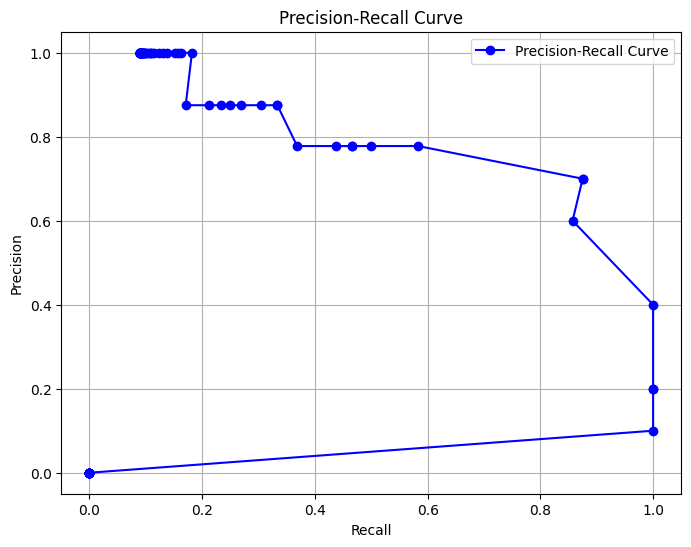

In [ ]:
from goal_evaluator import GoalEvaluator
# List of high-level goals 
#generated_goals = [goal.description for goal in highLevelGoals.goals]
generated_goals = ['Enable rapid annotation of genetic variants in cancer.', 'Provide automated interpretation of genetic variants in cancer.', 'Integrate existing data resources for comprehensive genetic insights.', 'Translate DNA changes to protein alterations for user understanding.', 'Assess functional impact of protein mutations for informed analysis.', 'Provide information on mutation frequencies for research utility.', 'Deliver gene function data to aid in variant analysis.', 'Interpret variant effects for clinical and research guidance.', 'Present clinical relevance of mutations for user reference.', "outlier"]
manual_goals = ["Provide fast and automated annotation of genetic variants", "Enable high-throughput interpretation of genetic variants", "Integrate information from various existing resources", "Convert DNA changes to protein changes", "Predict functional effects of protein mutations", "Provide information about mutation frequencies", "Offer insights into gene function", "Detail variant effects", "Highlight clinical actionability of variants"]
#generated_goals = ["View trail descriptions", "Record fitness data", "Send push notifications to users"]
#manual_goals = ["Browse trails", "View descriptions", "Record fitness data"]
evaluator = GoalEvaluator(preprocess = True)

evaluator.print_roc_prec_rec_curve(generated_goals, manual_goals)


In [ ]:
evaluator2 = GoalEvaluator(preprocess = False)

# Computes the Similarities Matrix
results = evaluator2.evaluate(generated_goals, manual_goals,0.85)

print("Precision:", results["precision"])
print("Recall:", results["recall"])
print("F1 Score:", results["f1_score"])
print("Similarities Matrix:", results["similarities"])

Precision: 0.8571428571428571
Recall: 0.75
F1 Score: 0.7999999995022221
Similarities Matrix: [[0.8982619  0.8496185  0.6100298  0.6533114  0.76715285 0.677038
  0.7171951  0.40201533 0.75421524]
 [0.8337025  0.8507133  0.6607107  0.7086705  0.8092898  0.7604251
  0.78178835 0.48889658 0.79795706]
 [0.8149216  0.80522496 0.85828197 0.6479548  0.69075245 0.733842
  0.7740383  0.5019614  0.6854527 ]
 [0.780015   0.77360296 0.7257144  0.82547    0.7903491  0.73542
  0.7780063  0.54469603 0.7122859 ]
 [0.80832803 0.8220601  0.668863   0.7287352  0.8848871  0.7439874
  0.7798312  0.53740585 0.83658653]
 [0.7745307  0.76382315 0.7478328  0.69512683 0.79239535 0.8850665
  0.80313605 0.58315754 0.76863825]
 [0.85209125 0.8489872  0.6836262  0.6866504  0.80996376 0.75151145
  0.77055997 0.47675204 0.762099  ]
 [0.7290589  0.743848   0.711334   0.6715676  0.7871947  0.7666164
  0.74786055 0.5867243  0.81899065]
 [0.7219324  0.73448277 0.7070222  0.6600082  0.7918509  0.75035083
  0.7477973  0.571

In [ ]:
similarities = results["similarities"]
# Trova il match migliore per ogni goal generato
for i, gen_goal in enumerate(generated_goals):
    best_match_idx = similarities[i].argmax()
    best_match_score = similarities[i].max()
    print(f"Generated goal: '{gen_goal}' -> Best match: '{manual_goals[best_match_idx]}' (Score: {best_match_score:.2f})")


Generated goal: 'Enable rapid annotation of genetic variants in cancer.' -> Best match: 'Provide fast and automated annotation of genetic variants' (Score: 0.90)
Generated goal: 'Provide automated interpretation of genetic variants in cancer.' -> Best match: 'Enable high-throughput interpretation of genetic variants' (Score: 0.85)
Generated goal: 'Integrate existing data resources for comprehensive genetic insights.' -> Best match: 'Integrate information from various existing resources' (Score: 0.86)
Generated goal: 'Translate DNA changes to protein alterations for user understanding.' -> Best match: 'Convert DNA changes to protein changes' (Score: 0.83)
Generated goal: 'Assess functional impact of protein mutations for informed analysis.' -> Best match: 'Predict functional effects of protein mutations' (Score: 0.88)
Generated goal: 'Provide information on mutation frequencies for research utility.' -> Best match: 'Provide information about mutation frequencies' (Score: 0.89)
Generated